# ICP-AES

Agilent 5110 ICP-OES

In [1]:
# force Jupyter to autoreload modules when they have been edited
# this helps keep the iodp module current as it is actively developed.
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
from importlib import reload

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from iodp import utils, icp




In [4]:
# Ensure we are in the Chemistry root folder
if not os.getcwd().endswith("Chemistry"):
    print("Current working directory:", os.getcwd())
    os.chdir("../")
    
print("New current working directory:", os.getcwd())

Current working directory: d:\archive\hd_files\data_analysis\50_laboratory_notebooks\SOD-Laboratory\Chemistry\notebooks
New current working directory: d:\archive\hd_files\data_analysis\50_laboratory_notebooks\SOD-Laboratory\Chemistry


# Read ICP .xlsx files

The .xlsx files contain raw data exported from ICP Expert software.

In [46]:
file = './data/input/ICP/400_IWICP_U1604_09Sep2023.xlsx'
df = pd.read_excel(file, engine='openpyxl', skiprows=3)
df

,Label,Type,Date Time,Element,Element Label,Flags,Unadjusted Data,Concentration,Unit,Intensity,...,Replicates,Concentration Replicate 1,Concentration Replicate 2,Concentration Replicate 3,Intensity Replicate 1,Intensity Replicate 2,Intensity Replicate 3,Flags Replicate 1,Flags Replicate 2,Flags Replicate 3
0,Acid Blank,BLK,2023-09-09 10:13:25,Ar 675.283,Ar,NaN,0,0,uM,1145793.27,...,3,0,0,0,1140736.5,1140706.01,1155937.29,NaN,NaN,NaN
1,Acid Blank,BLK,2023-09-09 10:13:25,Ar 675.283,Ar,NaN,0,0,uM,1149221.6,...,3,0,0,0,1126889.14,1157921.3,1162854.35,NaN,NaN,NaN
2,Acid Blank,BLK,2023-09-09 10:13:25,B 208.956,B,NaN,0,0,uM,6.38,...,3,0,0,0,9.53,1.78,7.82,NaN,NaN,NaN
3,Acid Blank,BLK,2023-09-09 10:13:25,B 249.678,B,NaN,0,0,uM,28.18,...,3,0,0,0,41.02,30.03,13.48,NaN,NaN,NaN
4,Acid Blank,BLK,2023-09-09 10:13:25,B 249.772,B,NaN,0,0,uM,27.33,...,3,0,0,0,33.4,28.76,19.83,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9159,Acid Blank,Sample,2023-09-09 13:16:55,Sr 407.771,Sr,u,-1.77,-1.77,uM,1544.49,...,3,-1.76,-1.77,-1.78,1841.9,1555.63,1235.93,u,u,u
9160,Acid Blank,Sample,2023-09-09 13:16:55,Sr 421.552,Sr,NaN,0.51,0.51,uM,25.05,...,3,0.52,0.51,0.51,47.03,36.38,-8.27,NaN,NaN,NaN
9161,Acid Blank,Sample,2023-09-09 13:16:55,Sr 421.552,Sr,NaN,1.03,1.03,uM,776.75,...,3,1.04,1.03,1.03,920.45,810.52,599.28,NaN,NaN,NaN
9162,Acid Blank,Sample,2023-09-09 13:16:55,Sr 460.733,Sr,u,0.89,0.89,uM,15.07,...,3,1.51,2.03,-0.88,56.53,90.84,-102.17,NaN,NaN,u


In [64]:

df.columns

Index(['Label', 'Type', 'Date Time', 'Element', 'Element Label', 'Flags',
       'Unadjusted Data', 'Concentration', 'Unit', 'Intensity',
       'Concentration SD', 'Concentration %RSD', 'Intensity SD',
       'Intensity %RSD', 'Weight', 'Volume', 'Dilution', 'Internal Standard',
       'Replicates', 'Concentration Replicate 1', 'Concentration Replicate 2',
       'Concentration Replicate 3', 'Intensity Replicate 1',
       'Intensity Replicate 2', 'Intensity Replicate 3', 'Flags Replicate 1',
       'Flags Replicate 2', 'Flags Replicate 3'],
      dtype='object')

In [65]:
df['Internal Standard'].value_counts()

Internal Standard
In (325.609 nm)    3248
Sc (361.383 nm)    2088
Sb (206.834 nm)    1392
Be (313.042 nm)     928
-                   696
In (230.606 nm)     696
Sc (424.682 nm)     116
Name: count, dtype: int64

In [52]:
df.columns

Index(['Label', 'Type', 'Date Time', 'Element', 'Element Label', 'Flags',
       'Unadjusted Data', 'Concentration', 'Unit', 'Intensity',
       'Concentration SD', 'Concentration %RSD', 'Intensity SD',
       'Intensity %RSD', 'Weight', 'Volume', 'Dilution', 'Internal Standard',
       'Replicates', 'Concentration Replicate 1', 'Concentration Replicate 2',
       'Concentration Replicate 3', 'Intensity Replicate 1',
       'Intensity Replicate 2', 'Intensity Replicate 3', 'Flags Replicate 1',
       'Flags Replicate 2', 'Flags Replicate 3'],
      dtype='object')

In [63]:
replace_values = ['####','Uncal']

df_r = (
    df.assign(
        Vial = lambda df_: df_['Label'].ne(df_['Label'].shift()).cumsum().astype(int),
    )
    .replace({'Concentration': replace_values, 'Intensity': replace_values}, None)
    .astype({'Concentration': float, 'Intensity': float}
        )
    )


df_pivot = df_r.pivot_table(
    index=['Vial','Label'],
    columns=['Element', 'Internal Standard'],
    values=['Intensity', 'Concentration'],
    aggfunc='mean'
)


df_pivot = df_pivot.reorder_levels(['Element', 'Internal Standard', None], axis=1).sort_index(axis=1)
df_pivot

Element                 Ar 675.283                    B 208.956            \
Internal Standard  In (325.609 nm)              Sb (206.834 nm)             
                     Concentration    Intensity   Concentration Intensity   
Vial Label                                                                  
1    Acid Blank                0.0  1147507.435            0.00      6.38   
2    STD 0%                    NaN  1150045.085             NaN     21.95   
3    STD 1%                    NaN  1161251.720           27.70     71.93   
4    STD 5%                    NaN  1156450.495          138.70    334.19   
5    STD 10%                   NaN  1134719.370          277.50    662.44   
...                            ...          ...             ...       ...   
112  IAPSO 0%                  NaN  1205954.690           12.35     43.68   
113  IN HOUSE 0%               NaN  1156214.450            3.55     22.92   
114  IAPSO 100%                NaN  1062093.720          438.75   1047.73   
115  IN HOUSE 100%             NaN  1130827.070         2775.25   6457.55   
116  Acid Blank                NaN  1107169.110           -1.31     11.44   

Element                  B 249.678                 B 249.772            \
Internal Standard  Sb (206.834 nm)           Sb (206.834 nm)             
                     Concentration Intensity   Concentration Intensity   
Vial Label                                                               
1    Acid Blank               0.00     28.18            0.00     27.33   
2    STD 0%                    NaN    156.77             NaN     84.79   
3    STD 1%                  27.70    681.07           27.70    396.73   
4    STD 5%                 138.70   3243.63          138.70   1925.92   
5    STD 10%                277.50   6396.26          277.50   3813.88   
...                            ...       ...             ...       ...   
112  IAPSO 0%                 8.98    346.90            7.59    214.71   
113  IN HOUSE 0%              0.21    147.48           -1.76     89.23   
114  IAPSO 100%             448.54  10340.68          462.79   6337.99   
115  IN HOUSE 100%         2789.77  63545.90         2843.06  38790.65   
116  Acid Blank              -3.77     57.06           -5.91     33.54   

Element                 Ba 230.424              ...      Si 288.158            \
Internal Standard  Sb (206.834 nm)              ... In (325.609 nm)             
                     Concentration   Intensity  ...   Concentration Intensity   
Vial Label                                      ...                             
1    Acid Blank              0.000       8.365  ...            0.00    859.22   
2    STD 0%                    NaN      17.600  ...             NaN    908.97   
3    STD 1%                  3.600    1596.285  ...            8.90   1178.63   
4    STD 5%                 18.200    8047.560  ...           44.50   2360.16   
5    STD 10%                36.400   16125.100  ...           89.00   3369.69   
...                            ...         ...  ...             ...       ...   
112  IAPSO 0%               -2.325       3.195  ...            3.01   1027.20   
113  IN HOUSE 0%            -2.285       7.520  ...           -1.65    899.35   
114  IAPSO 100%             -1.715     249.865  ...           26.25   1664.42   
115  IN HOUSE 100%         375.410  160736.525  ...          896.56  24930.60   
116  Acid Blank             -2.275      13.915  ...           -4.03    834.16   

Element                 Sr 215.283                 Sr 407.771                \
Internal Standard  In (325.609 nm)            In (230.606 nm)                 
                     Concentration  Intensity   Concentration     Intensity   
Vial Label                                                                    
1    Acid Blank              0.000    122.520           0.000  1.432550e+02   
2    STD 0%                    NaN    147.805             NaN  1.527590e+03   
3    STD 1%                  5.700    339.1

In [71]:
df_pivot.columns

MultiIndex([('Ar 675.283', 'In (325.609 nm)', 'Concentration'),
            ('Ar 675.283', 'In (325.609 nm)',     'Intensity'),
            ( 'B 208.956', 'Sb (206.834 nm)', 'Concentration'),
            ( 'B 208.956', 'Sb (206.834 nm)',     'Intensity'),
            ( 'B 249.678', 'Sb (206.834 nm)', 'Concentration'),
            ( 'B 249.678', 'Sb (206.834 nm)',     'Intensity'),
            ( 'B 249.772', 'Sb (206.834 nm)', 'Concentration'),
            ( 'B 249.772', 'Sb (206.834 nm)',     'Intensity'),
            ('Ba 230.424', 'Sb (206.834 nm)', 'Concentration'),
            ('Ba 230.424', 'Sb (206.834 nm)',     'Intensity'),
            ...
            ('Si 288.158', 'In (325.609 nm)', 'Concentration'),
            ('Si 288.158', 'In (325.609 nm)',     'Intensity'),
            ('Sr 215.283', 'In (325.609 nm)', 'Concentration'),
            ('Sr 215.283', 'In (325.609 nm)',     'Intensity'),
            ('Sr 407.771', 'In (230.606 nm)', 'Concentration'),
            ('Sr 407.771

In [85]:
x = df_pivot.loc[:18, [('Si 288.158', 'In (325.609 nm)', 'Concentration'),
            ('Si 288.158', 'In (325.609 nm)',     'Intensity')]]

type(x)

pandas.core.frame.DataFrame

In [91]:
x.columns = [i[2] for i in x.columns]

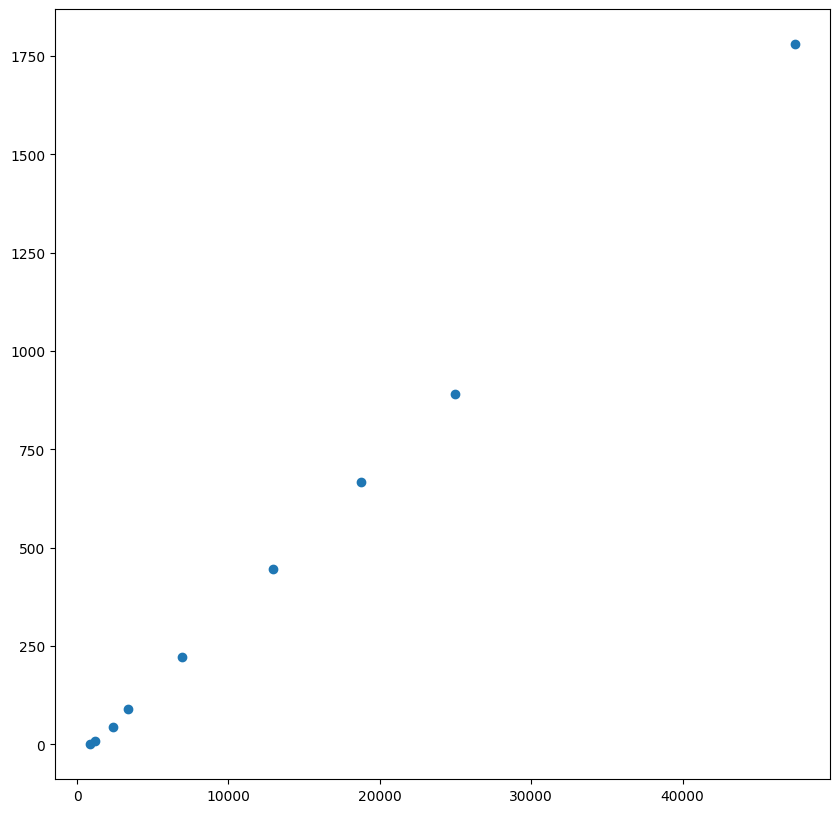

In [93]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(x=x['Intensity'], y=x['Concentration'])
plt.show()